## Trasnfer learning of a sequence to sequence transformer

In [2]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
import torch
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=256, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(model_dim, 1)

    def forward(self, x):
        # x shape: [batch, time, 1]
        x = self.input_proj(x)                     # [batch, time, model_dim]
        x = self.positional_encoding(x)           # Add position info
        x = self.transformer_encoder(x)           # [batch, time, model_dim]
        return self.output_proj(x)                # [batch, time, 1]


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        return x + self.pos_embedding(positions)

class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_dim=1, model_dim=256, num_heads=4, num_layers=4, dropout=0.1, max_len=10000):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dim_feedforward=512, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(model_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        x = self.input_proj(x)           # [batch, seq_len, model_dim]
        x = self.pos_encoder(x)          # Add learned positional encodings
        x = self.transformer(x)          # [batch, seq_len, model_dim]
        return self.output_proj(x)       # [batch, seq_len, 1]

In [60]:
model=TransformerSeq2Seq()
print(model)

TransformerSeq2Seq(
  (input_proj): Linear(in_features=1, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_proj): Linear(in_features=256, out_features=1, bias=True)
)


#### Dataloading

In [30]:
import numpy as np
import matplotlib.pyplot as plt

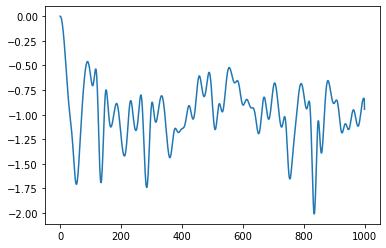

(10000, 1001, 1) (10000, 1001, 1)


In [59]:
data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-03-03_16-43.npz')

h_eff=data['h_eff'][:10000,]
h=data['h'][:10000,]

plt.plot(h_eff[100,1:,0])
plt.show()
print(h_eff.shape,h.shape)

In [61]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, h_array, f_array):
        self.h = torch.from_numpy(h_array).float()  # shape: [B, T, 1]
        self.f = torch.from_numpy(f_array).float()  # shape: [B, T, 1]

    def __len__(self):
        return len(self.h)

    def __getitem__(self, idx):
        return self.h[idx], self.f[idx]

In [62]:
from torch.utils.data import DataLoader, random_split

# Assume h_array and f_array are numpy arrays of shape [batch, time, 1]
dataset = TimeSeriesDataset(h, h_eff)

# Define split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 600

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    for h_batch,f_batch in train_loader:
        h_batch, f_batch = h_batch.to(device), f_batch.to(device)
        seq_len = 700
        x = h_batch[:, :seq_len]
        y = f_batch[:, :seq_len]
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # for h_batch, f_batch in train_loader:
    #     h_batch, f_batch = h_batch.to(device), f_batch.to(device)
        


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for h_batch, f_batch in val_loader:
            h_batch, f_batch = h_batch.to(device), f_batch.to(device)
            output = model(h_batch)
            loss = criterion(output, f_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.6f}, "
          f"Val Loss: {val_loss/len(val_loader):.6f}")

Epoch 1/600, Train Loss: 0.254909, Val Loss: 0.027025
Epoch 2/600, Train Loss: 0.015646, Val Loss: 0.022926
Epoch 3/600, Train Loss: 0.011088, Val Loss: 0.021329
Epoch 4/600, Train Loss: 0.009444, Val Loss: 0.022702


KeyboardInterrupt: 

#### Test

In [64]:
data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-03-03_16-43.npz')

h_eff=data['h_eff'][:100]
h=data['h'][:100]

h_tensor=torch.from_numpy(h)



In [65]:
model.eval()
model=model.to(device='cpu').to(dtype=torch.float)
h_eff_prediction=model(h_tensor.to(dtype=torch.float))

print(h_eff_prediction.shape,h_eff_prediction)

torch.Size([100, 1001, 1]) tensor([[[ 0.0223],
         [ 0.0251],
         [ 0.0260],
         ...,
         [-0.8252],
         [-0.8447],
         [-0.8654]],

        [[ 0.0336],
         [ 0.0351],
         [ 0.0354],
         ...,
         [-1.5876],
         [-1.5767],
         [-1.5575]],

        [[ 0.0347],
         [ 0.0378],
         [ 0.0386],
         ...,
         [-1.5755],
         [-1.5870],
         [-1.5941]],

        ...,

        [[ 0.0337],
         [ 0.0357],
         [ 0.0362],
         ...,
         [-0.8916],
         [-0.8888],
         [-0.8859]],

        [[ 0.0376],
         [ 0.0393],
         [ 0.0395],
         ...,
         [-1.3164],
         [-1.3186],
         [-1.3154]],

        [[ 0.0315],
         [ 0.0331],
         [ 0.0334],
         ...,
         [-2.0900],
         [-2.1119],
         [-2.1334]]], grad_fn=<ViewBackward0>)


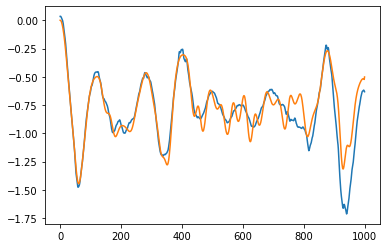

In [78]:
import matplotlib.pyplot as plt
idx=np.random.randint(0,100)
plt.plot(h_eff_prediction[idx,1:,0].detach().numpy())
plt.plot(h_eff[idx,1:,0])

plt.show()

#### Autoregressive case

In [79]:
import torch
import torch.nn as nn

class AutoRegressiveTransformer(nn.Module):
    def __init__(self, input_dim=2, model_dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.predictor = nn.Linear(model_dim, 1)

    def forward(self, h_f_seq):
        # h_f_seq: [batch, time, 2]  (concatenated [h(t), f(t)] input)
        x = self.input_proj(h_f_seq)              # [batch, time, model_dim]
        x = self.positional_encoding(x)           # Add position info
        x = self.transformer(x)                   # [batch, time, model_dim]
        return self.predictor(x)                  # [batch, time, 1]

In [ ]:
from tqdm import trange

model=AutoRegressiveTransformer()

num_epochs=100

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_loss=0.
for epoch in trange(num_epochs):
    for h_seq, f_seq in train_loader:
        h_seq=h_seq[:,:500]
        f_seq=f_seq[:,:500]
        input_seq = torch.cat([h_seq, f_seq], dim=-1)  # [batch, T, 2]
        target = f_seq

        output = model(input_seq)
        loss = criterion(output[:, :-1], target[:, 1:])  # predict f(t+1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        print(loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.6f}, ")
    
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

0.5857499837875366
0.7614897787570953
1.11081662774086
1.507107436656952
1.7868711352348328
1.9481360018253326


  0%|          | 0/100 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def autoregressive_forecast(model, h_seq, f_start, steps):
    """
    h_seq: [1, T+steps, 1]  (known exogenous values)
    f_start: [1, T, 1]      (initial known target values)
    """
    preds = []
    f_seq = f_start.clone()

    for t in range(steps):
        inp = torch.cat([h_seq[:, :f_seq.shape[1]], f_seq], dim=-1)
        out = model(inp)
        next_f = out[:, -1:]   # last time step
        f_seq = torch.cat([f_seq, next_f], dim=1)
        preds.append(next_f)

    return torch.cat(preds, dim=1)  # [1, steps, 1]